In [1]:
### Hide the input codes   ###
from IPython.display import HTML
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


# UnifiedDataLayers
*Author: Sina Kashuk*

### Summary: 
One of the applications of hexagons is to be able to combine different datasets with different geographic shapes and forms. In this tutorial we are going through an example of how to bring the US census data, NYC 311 Noise complaints, and Digital Elevation Model to the hexagon aperture and then how to visualize the data to gain insight.

### Data
* **POLYGON:** Census Tract Data [[Source]](https://www.census.gov/data.html)
* **POINT:** NYC 311 noise complaints [[Source]](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/7ahn-ypff)
* **RASTER:** NYC Digital Elevation Model [[Source]](https://data.cityofnewyork.us/City-Government/1-foot-Digital-Elevation-Model-DEM-Integer-Raster/7kuu-zah7/)

In [2]:
# modified data link
ct_data_link = 'https://gist.githubusercontent.com/kashuk/e6e3e3d8fde34da1212b59248a7cc5a8/raw/da3b63c1c0ef4a1c8cc8e10f61455c436a0d0ad9/CT_data.csv'
ct_shape_link = 'https://gist.githubusercontent.com/kashuk/d73342adeccbc65de7a53e19ad78b4df/raw/4300dcb80861d454ecae8f8429166e196779fc21/CT_simplified_shape.json'
noise_311_link = 'https://gist.githubusercontent.com/kashuk/670a350ea1f9fc543c3f6916ab392f62/raw/4c5ced45cc94d5b00e3699dd211ad7125ee6c4d3/NYC311_noise.csv'
nyc_dem_link = 'https://gist.githubusercontent.com/kashuk/a08dc8f65b1b1aebafdcab9c0eda3346/raw/4d1cf7a306327f3570ddd6e4979e568ee82c2c71/dem_nyc_encoded.tif'

### Import & Functions

In [3]:
# import
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import shapely
import geopandas
from geopandas import GeoDataFrame
from shapely.geometry import mapping
from shapely.ops import cascaded_union#, unary_union
import h3
import base64
import urllib
import tempfile
# import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#Functions
def plot_scatter(df, metric_col, x='lng', y='lat', marker='.', alpha=1, figsize=(16,12), colormap='viridis'):    
    df.plot.scatter(x=x, y=y, c=metric_col, title=metric_col
                    , edgecolors='none', colormap=colormap, marker=marker, alpha=alpha, figsize=figsize);
    plt.xticks([], []); plt.yticks([], [])

def aperture_downsampling(df, hex_col, metric_col, coarse_aperture_size):
    df_coarse = df.copy()
    coarse_hex_col = 'hex{}'.format(coarse_aperture_size)
    df_coarse[coarse_hex_col] = df_coarse[hex_col].apply(lambda x: h3.h3_to_parent(x,coarse_aperture_size))
    dfc = df_coarse.groupby([coarse_hex_col])[[metric_col,]].mean().reset_index()
    dfc['lat'] = dfc[coarse_hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfc['lng'] = dfc[coarse_hex_col].apply(lambda x: h3.h3_to_geo(x)[1]) 
    return dfc

def kring_smoothing(df, hex_col, metric_col, k):
    dfk = df[[hex_col]] 
    dfk.index = dfk[hex_col]
    dfs =  (dfk[hex_col]
                 .apply(lambda x: pd.Series(list(h3.k_ring(x,k)))).stack()
                 .to_frame('hexk').reset_index(1, drop=True).reset_index()
                 .merge(df[[hex_col,metric_col]]).fillna(0)
                 .groupby(['hexk'])[[metric_col]].sum().divide((1 + 3 * k * (k + 1)))
                 .reset_index()
                 .rename(index=str, columns={"hexk": hex_col}))
    dfs['lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['lng'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1]) 
    return dfs

def weighted_kring_smoothing(df, hex_col, metric_col, coef):
    # normalize the coef
    a = []
    for k, coe in enumerate(coef):
        if k == 0:
            a.append(coe)
        else:
            a.append(k * 6 * coe)
    coef = [c / sum(a) for c in coef]
    
    # weighted smoothing 
    df_agg = df[[hex_col]]
    df_agg['hexk'] = df_agg[hex_col]
    df_agg.set_index(hex_col,inplace=True)
    temp2 = [df_agg['hexk'].reset_index()]
    temp2[-1]['k'] = 0
    K=len(coef)-1 
    for k in range(1,K+1):
        temp2.append((df_agg['hexk']
                     .apply(lambda x: pd.Series(list(h3.hex_ring(x,k)))).stack()
                     .to_frame('hexk').reset_index(1, drop=True).reset_index()
                ))
        temp2[-1]['k'] = k
    df_all = pd.concat(temp2).merge(df)
    df_all[metric_col] = df_all[metric_col]*df_all.k.apply(lambda x:coef[x])
    dfs = df_all.groupby('hexk')[[metric_col]].sum().reset_index().rename(index=str, columns={"hexk": hex_col})
    dfs['lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['lng'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
    return dfs

# Data 

## Point to Hex

### Load 311 Noise Complaints

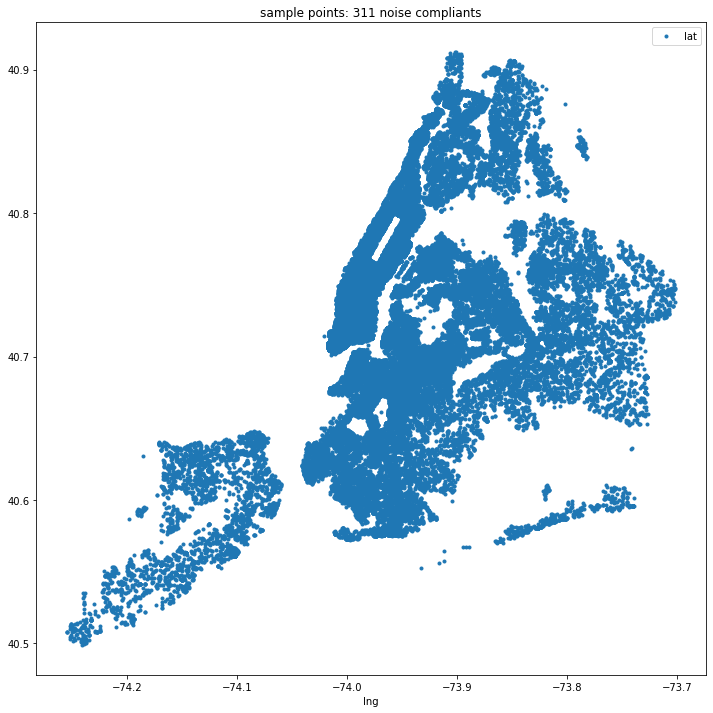

In [4]:
# load the 311 noise complaints 
df311 = pd.read_csv(noise_311_link)

# Visualize the 311 noise complaints points
df311.plot(x='lng',y='lat',style='.',alpha=1,figsize=(12,12));
plt.title('sample points: 311 noise compliants');

### 311 Point to Hex

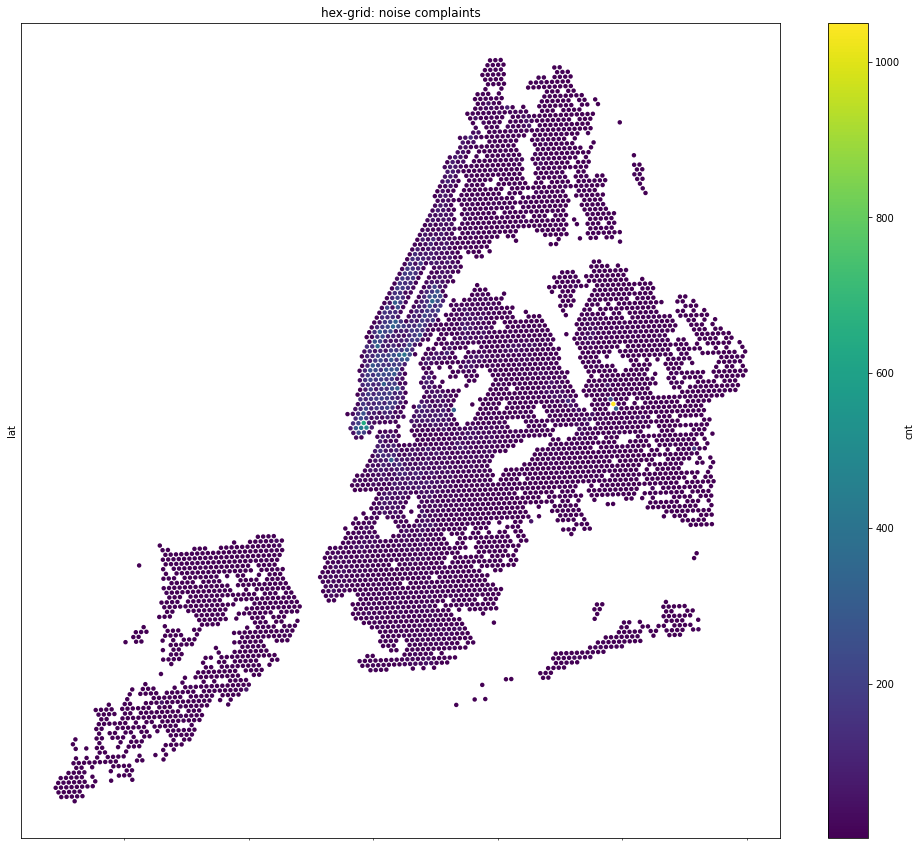

In [5]:
APERTURE_SIZE = 9
hex_col = 'hex'+str(APERTURE_SIZE)

# find hexs containing the points
df311[hex_col] = df311.apply(lambda x: h3.geo_to_h3(x.lat,x.lng,APERTURE_SIZE),1)

# aggregate the points
df311g = df311.groupby(hex_col).size().to_frame('cnt').reset_index()

#find center of hex for visualization
df311g['lat'] = df311g[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
df311g['lng'] = df311g[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

# pltot the hexs
plot_scatter(df311g, metric_col='cnt', marker='o',figsize=(17,15))
plt.title('hex-grid: noise complaints');

### Spatial Smoothing

sum sanity check: 1.0


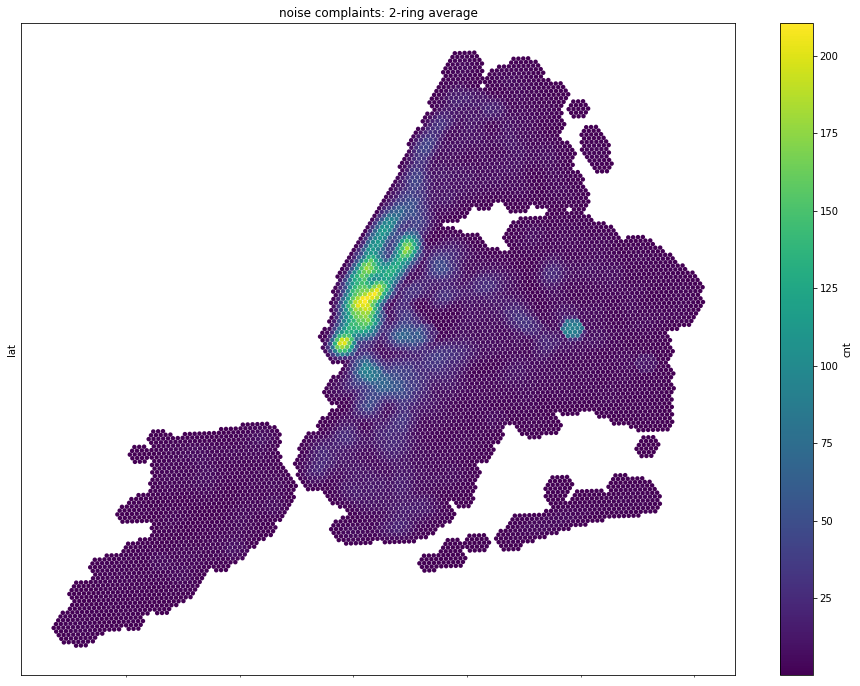

In [6]:
#kring_smoothing
k = 2
df311s= kring_smoothing(df311g, hex_col, metric_col='cnt', k=k)
print('sum sanity check:', df311s['cnt'].sum() / df311g['cnt'].sum())
plot_scatter(df311s, metric_col='cnt', marker='o')
plt.title('noise complaints: 2-ring average');

## Polygon to Hex

### Load Census Tract Data

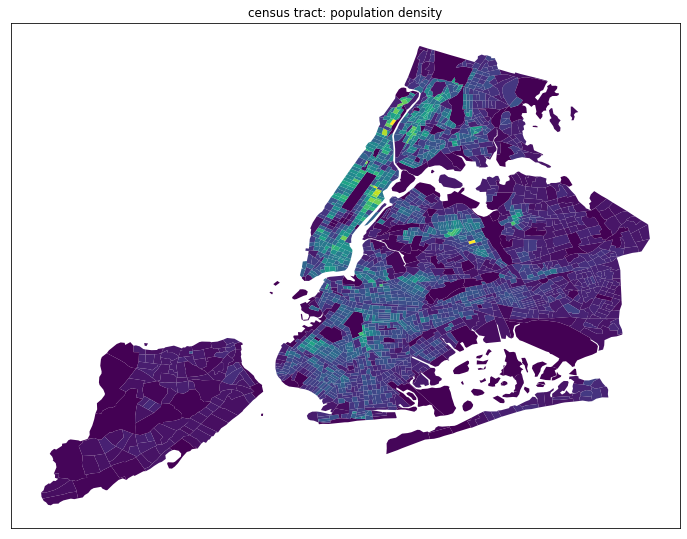

In [7]:
METRIC_COL = 'SE_T002_002' #population density

# Load Census Tract (CT) ShapeFile
gdf=GeoDataFrame.from_file(ct_shape_link)
gdf['gdf'] = gdf['BoroCT2010'].astype(str) 

# Load CT Data & Join w/ ShapeFile
df = pd.read_csv(ct_data_link, usecols=['BoroCT2010',METRIC_COL])
df['BoroCT2010'] = df['BoroCT2010'].astype(str)

# join metadata
gdf = df.merge(gdf).fillna(0)
gdf.crs = {"init": "epsg:4326"}
gdf.sample(3)

# Visualize Population Density per Census Tract
f, ax = plt.subplots(figsize=(12,12)); 
ax.get_xaxis().set_visible(False); 
ax.get_yaxis().set_visible(False)
GeoDataFrame(gdf).plot(column=METRIC_COL,colormap='viridis',alpha=1,linewidth=0.05,ax=ax)
plt.title('census tract: population density');

### Census Polygon to Hex 

0 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 
25 
26 
27 
28 
29 
30 
31 
32 
33 
34 
35 
36 
37 
38 
Sanity Check
number of hexes: 51673
number of duplicates: 0


ValueError: 'left_df' should be GeoDataFrame, got <class 'pandas.core.frame.DataFrame'>

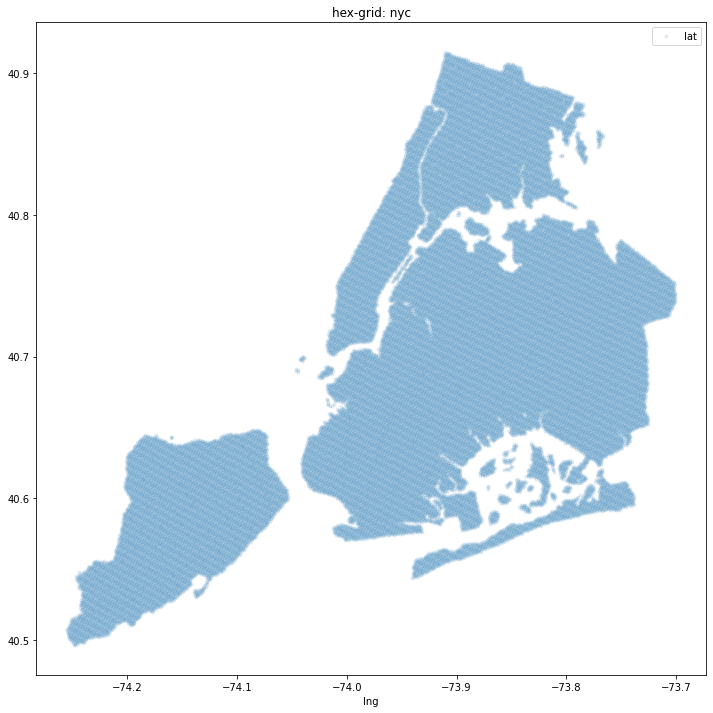

In [8]:
APERTURE_SIZE = 10 
# Unify the CT boundries
union_poly = cascaded_union(gdf.geometry)

# Find the hexs within the city boundary using PolyFill
hex_list=[]
for n,g in enumerate(union_poly):
    print(n,'\r')
    temp  = mapping(g)
    temp['coordinates']=[[[j[1],j[0]] for j in i] for i in temp['coordinates']]  
    hex_list.extend(h3.polyfill(temp,APERTURE_SIZE))

# create hex dataframe
hex_col = 'hex{}'.format(APERTURE_SIZE)
dfh = pd.DataFrame(hex_list,columns=[hex_col])
print('Sanity Check\nnumber of hexes:', len(hex_list))
print('number of duplicates:', len(hex_list) - len(dfh.drop_duplicates()))

# add lat & lng of center of hex 
dfh['lat']=dfh[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
dfh['lng']=dfh[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

# create Point object based on hex latlng
dfh['geometry'] = dfh.apply(lambda x: shapely.geometry.Point(x.lng,x.lat),1)
dfh.crs = {"init": "epsg:4326"}

# plot hex latlng
dfh.plot(x='lng',y='lat',style='.',alpha=.1,figsize=(12,12));
plt.title('hex-grid: nyc')
# Intersect Hex Point with CT Polygon
df_ct = geopandas.tools.sjoin(gdf, dfh, how="inner")
df_ct.sample(3)

# Visualize Hexagons
plot_scatter(df_ct, metric_col=METRIC_COL, marker='.')
plt.title('hex-grid: population density');

### Spatial Weighted Smoothing

In [ ]:
# kring smoothing coefficients
coef = [1, .8, .4, .15, 0.05]
plt.plot(coef)
plt.xlabel('K-ring')
plt.ylabel('Smoothing Coef')

# weighted kring smoothing
df_ct_kw = weighted_kring_smoothing(df_ct, hex_col, metric_col=METRIC_COL, coef=coef)
print('sum sanity check:', df_ct_kw[METRIC_COL].sum() / df_ct[METRIC_COL].sum())
plot_scatter(df_ct_kw, metric_col=METRIC_COL, marker='.')
plt.title('hex-grid: smoothed population density');

### Spatial Hierarchical 

In [ ]:
# Spatial Hierarchy using h3_to_parent
coarse_aperture_size = 9
df_coarse = aperture_downsampling(df_ct_kw, hex_col, metric_col=METRIC_COL, coarse_aperture_size=coarse_aperture_size)
print('number of hex:', len(df_ct_kw))
print('number of coarse hex:', len(df_coarse))
plot_scatter(df_coarse, metric_col=METRIC_COL, marker='o')
plt.title('hex-grid: population density');

In [ ]:
# Aperture 8
_ = aperture_downsampling(df_ct, hex_col, metric_col=METRIC_COL, coarse_aperture_size=8)
plot_scatter(_ , metric_col=METRIC_COL, marker='o',figsize=(8,6))
plt.title('hex-grid: population density');

## Raster to Hex

### Load Digital Elevation Model Data

In [ ]:
# create temp directory for GeoTiff file processing
temp_dir = tempfile.mkdtemp()

# download & decode GeoTiff data
open(temp_dir+'nyc_dem.tif', 'wb').write(base64.b64decode(urllib.urlopen(nyc_dem_link).read()))

# translate GeoTiff to XYZ points
!gdal_translate -of XYZ  $temp_dir'nyc_dem.tif' $temp_dir'nyc_dem.xyz'

# read xyz points
df = pd.read_csv(temp_dir+'nyc_dem.xyz',sep=' ',header=None,names=['lng','lat','elevation'])

# ignore the missing values
df = df[df.elevation>-1000]

# remove temp directory
!rm -r $temp_dir 

# Visualize the elevation
plot_scatter(df, metric_col='elevation', marker='.', colormap='gray')

### DEM Raster to Hex

In [ ]:
APERTURE_SIZE = 9
hex_col = 'hex'+str(APERTURE_SIZE)

# find hexs containing the points
df[hex_col] = df.apply(lambda x: h3.geo_to_h3(x.lat,x.lng,APERTURE_SIZE),1)

# calculate elevation average per hex
df_dem = df.groupby(hex_col)['elevation'].mean().to_frame('elevation').reset_index()

#find center of hex for visualization
df_dem['lat'] = df_dem[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
df_dem['lng'] = df_dem[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

# pltot the hexs
plot_scatter(df_dem, metric_col='elevation', marker='o')
plt.title('hex-grid: elevation');

# Unifying Data Layers

In [ ]:
dfu = df_coarse[[METRIC_COL,hex_col]].merge(df311s[[hex_col,'cnt']]).merge(df_dem[[hex_col,'elevation']])
dfu.set_index(hex_col,inplace=True)
dfu.rename(index=str, columns={METRIC_COL: "population","cnt":"noise_complaints"},inplace=True)
dfu.population = dfu.population.clip_upper(dfu.population.quantile(.9))
dfu.noise_complaints = dfu.noise_complaints.clip_upper(dfu.noise_complaints.quantile(.9))
dfu.elevation = dfu.elevation.clip_upper(dfu.elevation.quantile(.9))
pd.scatter_matrix(dfu, alpha=0.05,figsize=(15,15));
# dfu['lat']=dfu['hex10'].apply(lambda x: h3.h3_to_geo(x)[0])
# dfu['lng']=dfu['hex10'].apply(lambda x: h3.h3_to_geo(x)[1])
dfu.describe()